# Trabalho 2 
Classificação não supervisionado utilizando agrupamento hierárquico.

## Carregando os dados

In [1]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import AgglomerativeClustering

def plot_images(data, n_img_per_row=10, cmap='gray'):
    """Exibe várias imagens do conjunto de dados
    """
    shape = int(np.sqrt(len(data[0])))
    full_img = np.zeros((shape * n_img_per_row, shape * n_img_per_row))
    for i in range(n_img_per_row):
        ix = shape * i
        for j in range(n_img_per_row):
            iy = shape * j
            img = data[i * n_img_per_row + j].reshape((shape, shape))
            full_img[ix:ix + shape, iy:iy + shape] = img

    plt.figure(figsize=(8, 8))
    plt.imshow(full_img, cmap=cmap)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [2]:
original_df_train = pd.read_csv('data/mnist_train.csv', dtype=np.uint8)

In [3]:
df = original_df_train.copy()
df

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to 28x28
dtypes: uint8(785)
memory usage: 44.9 MB


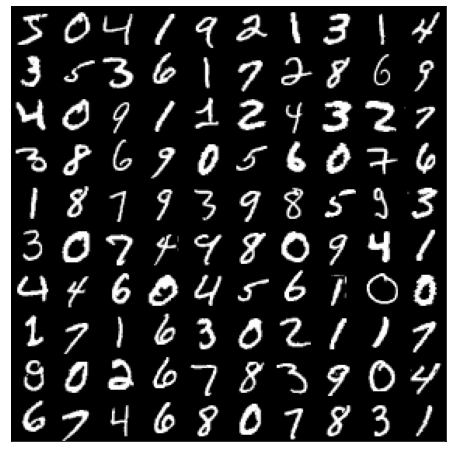

In [5]:
plot_images(df.iloc[:, 1:].to_numpy())

In [6]:
X, Y = df.iloc[:, 1:].to_numpy(), df.iloc[:, :1].to_numpy().transpose()[0]

## Realizando a redução de dimensionalidade com t-SNE para 30.000 amostras

In [7]:
idx = 30000
t0 = time()
X_embedding = TSNE(n_components=2, random_state=42, n_jobs=4).fit_transform(X[:idx])
t1 = time()
tempo_tsne = t1 - t0
print(f'Tempo de execução TSNE: {tempo_tsne:.5g} seg')

Tempo de execução TSNE: 115.24 seg


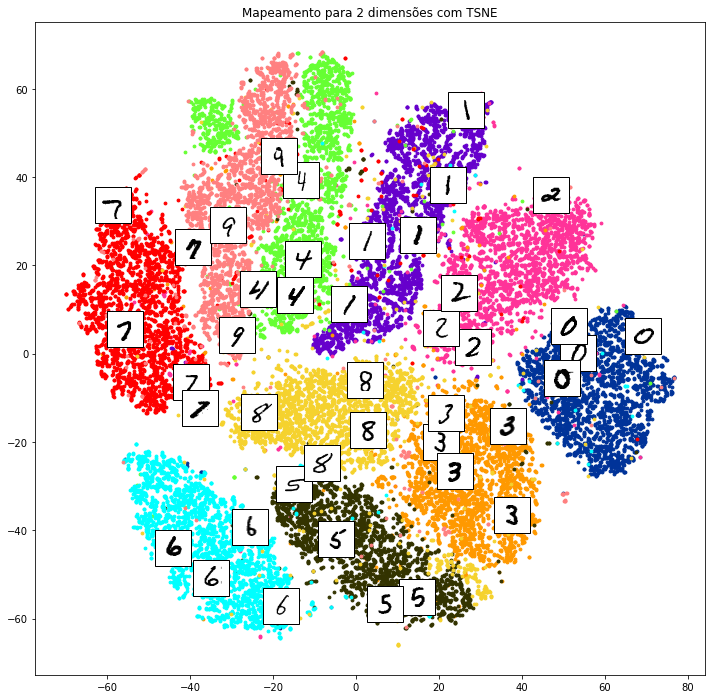

In [8]:
# visualização do mapeamento para 2 dimenões

colors = ['#003399', '#6600cc', '#ff3399', '#ff9900', '#66ff33', '#333300',
    '#00ffff', '#ff0000', '#f5d22e', '#ff8080'
]
col_dict = {}
for i in range(10):
    col_dict[i] = colors[i]

# plot adaptado de https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#sphx-glr-auto-examples-manifold-plot-lle-digits-py
fig, axs = plt.subplots(figsize=(12, 12))
shown_images = np.array([[1.0, 1.0]])
for group in range(10):
    ix = np.where(Y[:idx] == group)[0]
    axs.scatter(X_embedding[ix, 0], X_embedding[ix, 1], s=8, c=colors[group], label=group)
    for k in np.random.choice(ix, 5, replace=False):
        dist = np.sum((X_embedding[k] - shown_images) ** 2, 1)
        if np.min(dist) < 25:
            continue
        shown_images = np.concatenate([shown_images, [X_embedding[k]]], axis=0)
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(X[k].reshape(28, 28), cmap=plt.cm.gray_r), X_embedding[k]
        )
        axs.add_artist(imagebox)
plt.title('Mapeamento para 2 dimensões com TSNE')
plt.show()

## Classificação e validação

In [9]:
# sem redução de dimensionalidade
t0 = time()
pred_764 = AgglomerativeClustering(n_clusters=10, compute_full_tree=True).fit_predict(X[:idx, :])
t1 = time()
tempo_764 = t1 - t0
ari_764 = adjusted_rand_score(pred_764, Y[:idx])
print(f'ARI: {ari_764:.3f}')
print(f'Tempo de execução AgglomerativeClustering 764 dimensões: {tempo_764:.5g} seg')

ARI: 0.517
Tempo de execução AgglomerativeClustering 764 dimensões: 365.32 seg


In [10]:
# com redução de dimensionalidade
t0 = time()
pred_2 = AgglomerativeClustering(n_clusters=10, compute_full_tree=True).fit_predict(X_embedding)
t1 = time()
tempo_2 = t1 - t0
ari_2 = adjusted_rand_score(pred_2, Y[:idx])
print(f'ARI: {ari_2:.3f}')
print(f'Tempo de execução AgglomerativeClustering 2 dimensões: {tempo_2:.5g} seg')

ARI: 0.759
Tempo de execução AgglomerativeClustering 2 dimensões: 26.536 seg


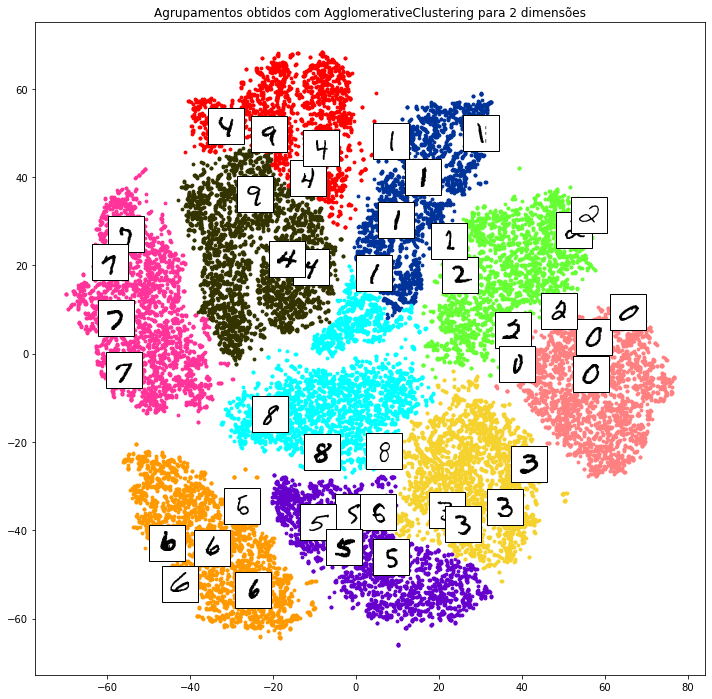

In [11]:
# plot adaptado de https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#sphx-glr-auto-examples-manifold-plot-lle-digits-py
fig, axs = plt.subplots(figsize=(12, 12))
shown_images = np.array([[1.0, 1.0]])
for group in range(10):
    ix = np.where(pred_2 == group)[0]
    axs.scatter(X_embedding[ix, 0], X_embedding[ix, 1], s=8, c=colors[group], label=group)
    for k in np.random.choice(ix, 5, replace=False):
        dist = np.sum((X_embedding[k] - shown_images) ** 2, 1)
        if np.min(dist) < 25:
            continue
        shown_images = np.concatenate([shown_images, [X_embedding[k]]], axis=0)
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(X[k].reshape(28, 28), cmap=plt.cm.gray_r), X_embedding[k]
        )
        axs.add_artist(imagebox)
plt.title('Agrupamentos obtidos com AgglomerativeClustering para 2 dimensões')
plt.show()